<a href="https://colab.research.google.com/github/chaeyoonyunakim/Data-Science/blob/main/working_with_digit_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


***Import Datasets***
=====================
This notebook is to begin a tutorial with tensor using the [Kaggle's Digit Recognizer dataset](https://www.kaggle.com/c/digit-recognizer/overview).

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
train_df = pd.read_csv('/content/drive/MyDrive/digit-recognizer/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/digit-recognizer/test.csv')

In [9]:
train_df.head(1)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
test_df.head(1)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


***Pre-processing***

In [12]:
x_train = train_df.drop(['label'], axis=1).values
y_train = train_df['label'].values

x_test = test_df.values

print(x_train.shape, y_train.shape, x_test.shape)

(42000, 784) (42000,) (28000, 784)



***Tensors***
=====================

"Tensors are a specialized data structure that are very similar to arrays
and matrices. In PyTorch, we use tensors to encode the inputs and
outputs of a model, as well as the model’s parameters.

Tensors are similar to NumPy’s ndarrays, except that tensors can run on
GPUs or other specialized hardware to accelerate computing. If you’re familiar with ndarrays, you’ll
be right at home with the Tensor API. If not, follow along in this quick
API walkthrough."

In [13]:
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


***Build a Digit Recognizer***
=====================

This PyTorch CNN for digit recognition uses tensors to handle the data. Like NumPy's ndarrays, tensors are to present the pixel values of the handwritten digits to the labels they represent. The code is built with layers.

The convolution layers (`conv_layers`) to initiate feature-finding, that I've constructed with followings:
- **nn.Conv2d** layers are picking patterns in the images. <br>
- **nn.ReLU** (Rectified Linear Unit) is a non-linear function to help the model learn details than simple linear operations could perform. <br>
- **nn.MaxPool2d** layers shrink the image data, to narrow down the focus on the most important features and to make it less sensitive to the minor changes in the input data. <br>

In [18]:
# Define the CNN architecture
class DigitRecognizer(nn.Module):
  def __init__(self):
    super(DigitRecognizer, self).__init__()

    self.conv_layers = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),

        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),

        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),

        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),

        nn.MaxPool2d(kernel_size=2, stride=2),
    )

    self.fc_layers = nn.Sequential(
        nn.Linear(64 * 7 * 7, 256),
        nn.ReLU(inplace=True),
        nn.Linear(256, 10),
    )

  def forward(self, x):
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1)
    x = self.fc_layers(x)

    return x

It starts from the input 1 channel (for grayscale images), and pass to the sequencial number `Conv2d` 16, 32, then 64 channels. Therefore, the tensor x in 2D shape (`num_channels`=64, `height`=7, `width`=7, `out_features`=256) has been flattend then goes into the fully connected layer (`fc_layers`) that makes a decision mapping the linear layer to one of the ten possible digits (0-9).

In [19]:
# Creat a model
model = DigitRecognizer()
model = model.to(device)

In [20]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

***Training***
=====================

This code is to train the model. Using `nn.CrossEntropyLoss` is to measure how far off the model's predictions are from the actual digits. The `optim.Adam` optimiser comes in to achieve the goal of finding the smallest loss. `optimizer.zero_grad()` is clearning any leftover calculations from the previous step, and then `loss.backward()` configures how each parameter contributed to the error. Final `optimizer.step()` will make the adjustments to those parameters. 

In [21]:
num_epochs = 50
losses = []
model.train()
for epoch in range(num_epochs):
  running_loss = 0.0
  for images, labels in train_loader:
    images = images.to(device).view(-1, 1, 28, 28)
    labels = labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    running_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  losses.append(running_loss/len(train_loader))
  print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.8f}')

Epoch 1/50, Loss: 0.16121433
Epoch 2/50, Loss: 0.04457396
Epoch 3/50, Loss: 0.03489643
Epoch 4/50, Loss: 0.02580169
Epoch 5/50, Loss: 0.02175457
Epoch 6/50, Loss: 0.02036925
Epoch 7/50, Loss: 0.01860531
Epoch 8/50, Loss: 0.01471195
Epoch 9/50, Loss: 0.01516160
Epoch 10/50, Loss: 0.01195014
Epoch 11/50, Loss: 0.01384945
Epoch 12/50, Loss: 0.01109979
Epoch 13/50, Loss: 0.01101656
Epoch 14/50, Loss: 0.01049004
Epoch 15/50, Loss: 0.01275043
Epoch 16/50, Loss: 0.00746662
Epoch 17/50, Loss: 0.01104387
Epoch 18/50, Loss: 0.01067571
Epoch 19/50, Loss: 0.00615961
Epoch 20/50, Loss: 0.00957828
Epoch 21/50, Loss: 0.01293004
Epoch 22/50, Loss: 0.00658469
Epoch 23/50, Loss: 0.00667940
Epoch 24/50, Loss: 0.00819412
Epoch 25/50, Loss: 0.00817809
Epoch 26/50, Loss: 0.01388895
Epoch 27/50, Loss: 0.00763570
Epoch 28/50, Loss: 0.00343908
Epoch 29/50, Loss: 0.01146673
Epoch 30/50, Loss: 0.00983372
Epoch 31/50, Loss: 0.00451070
Epoch 32/50, Loss: 0.00828516
Epoch 33/50, Loss: 0.00631646
Epoch 34/50, Loss: 

***Visualise the loss***
=====================

This code is to evaluate the model how well it's learned. The visualisation of loss will display the loss over training time.

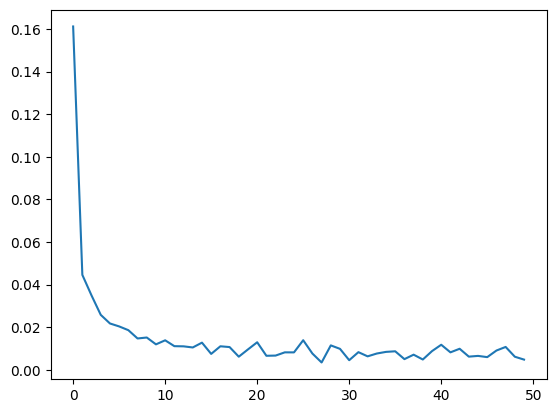

In [23]:
losses = np.array(losses)

plt.plot(losses)
plt.show()

***Test***
=====================

This code is to predict the test dataset.

In [24]:
predictions = []
model.eval()
with torch.no_grad():
  for images in test_loader:
    images = images[0].to(device).view(-1, 1, 28, 28)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    predictions.extend(predicted.cpu().numpy())

***Export CSV output***
=====================
This notebook is to submit a tutorial output to the [Kaggle's Digit Recognizer competition](https://www.kaggle.com/c/digit-recognizer/overview).

In [25]:
submission_df = pd.DataFrame({'ImageID': range(1, len(predictions)+1), 'label': predictions})
submission_df.head(5)

,ImageID,label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [26]:
submission_df.to_csv('submission.csv', index=False)